In [118]:
# This notebook is aimed to deal with the transiant state

In [119]:
#@title some needed code

# Includes the functions for data processing.
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler

import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader

def read_csv_as_ndarray(file_path: str, skip_rows: list, skip_columns: list) -> np.ndarray:
    '''
    This function reads in data located in FILEPATH and return a ndarray with specific ROWs and COLUMNs skipped.

    In skip_rows/columns, the elements should be the index of the rows/columns want to be skipped.
    '''


    df = pd.read_csv(file_path)

    assert type(skip_columns) == list, "Parameter skip_columns must be a list"
    assert type(skip_rows) == list, "Parameter skip_rows must be a list"

    # drop the specified rows and columns from the DataFrame
    df = df.drop(df.index[skip_rows], axis=0)  # drop rows by index
    df = df.drop(df.columns[skip_columns], axis=1)  # drop columns by index

    return df.values


def standarlize(data : np.ndarray):
    '''
    This function take a np.ndarray() as a input and standarlize it over columns
    '''
    ss = StandardScaler()

    return ss.fit_transform(data)

def generate_histogram(data: np.ndarray, binInt = 1.0e-06, binMax = 1.5e-04):
    '''
    Take in a data with first n-1 columns are features and last column are labels. Transform the features with histogram method
    '''

    # Extract data
    Xvals = data[:,0:-1]
    Yvals = data[:,-1]
    nRows, nCols = Xvals.shape

    # define bins
    hEdges = np.arange(0, binMax+binInt, binInt)
    nBins = len(hEdges)-1


    # fill histogram matrix
    nCountsX = np.zeros((nRows, nBins), dtype=np.uint16)
    for n in range(nRows):
        nCountsX[n,:], _ = np.histogram(Xvals[n,:], hEdges)

    # add the labels back
    result = np.concatenate((nCountsX, Yvals[:, np.newaxis]), axis=1)

    return result


# define the dataset classes
class ReactorData(Dataset):
    '''
    Define the pytorch dataset

    The input data must a np.ndarray with last column be the labels and all other columns be the features 

    Note that since the return data is a time sequence data, there maybe some data in the end of dataset is not used.

    '''
    def __init__(self, data, sequence_length, start_percent, end_percent):
        
        self.all_data = data
        length = data.shape[0]
        data = data[ int(length * start_percent)  : int(length * end_percent)]
        
        self.labels = data[:, -1:]
        self.data = data[:, 0:-1]
        self.sequence_length = sequence_length

        self.length = len(self.labels)//self.sequence_length

        # cut the out datas

        self.data = self.data[:self.sequence_length * self.length]

        self.labels = self.labels[:self.sequence_length * self.length]

        self.unshaped_data = self.data
        self.unshaped_labels = self.labels

        self.data = self.data.reshape(( self.length, self.sequence_length, self.data.shape[1]))

        self.labels = self.labels.reshape(( self.length, self.sequence_length,1))
        

        
    
    def __len__(self):
        return self.length
    
    def __getitem__(self,idx):
        return torch.tensor(self.data[idx], dtype = torch.double), \
    torch.tensor(self.labels[idx], dtype = torch.double)

    # Includes the neural nets

import torch.nn as nn
import torch





import torch
import torch.nn as nn

class SimpleLSTM(nn.Module):
    '''
    The simplest neural nets
    The structure likes this:

    BatchNorm -> LSTM layers -> Drop out layer -> Linear layer

    '''
    def __init__(self, input_dim = 150, hidden_dim = 64, output_dim = 1, lstm_nums_layer = 2, dropout = 0.1):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.batch_norm = nn.BatchNorm1d(input_dim)
        self.LSTM = nn.LSTM(input_dim, hidden_dim, lstm_nums_layer, batch_first = True)
        self.dropout = nn.Dropout(dropout)

        self.hidden_to_output = nn.Linear(hidden_dim, output_dim)

        self.to(torch.double)

    def forward(self, input):
        # print(input.shape)

        # Permute the input tensor to apply batch normalization along the time dimension
        input = input.permute(0, 2, 1)
        input = self.batch_norm(input)
        input = input.permute(0, 2, 1)

        hidden_state, _ = self.LSTM(input)

        # print(hidden_state.shape)
        output = self.dropout(hidden_state)
        output = self.hidden_to_output(output)

        return output



# Include some training method
from torch.utils.data import Dataset, DataLoader

# from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV


def train(model, training_data, epoch_num ,batch_size, optimizer, loss_fn, print_out_frequency, shuffle, device):
    '''
    Simplest trainning function, take in a model, train it with corrsponding hyper parameters , loss and optimizer. 
    Return the final trained model and loss value
    '''

    train_dataloader = DataLoader(training_data, batch_size = batch_size, shuffle= shuffle)


    for epoch in range(epoch_num):
        for batch, (X, y) in enumerate(train_dataloader):

            X = X.to(device)
            y = y.to(device)
            model.zero_grad()

            # print(X.dtype)
            pred = model(X)

            # print(pred)
            loss = loss_fn(pred, y)
        
            # backpropagation
            loss.backward()
            optimizer.step()
        
            loss = loss.item()

        if epoch % print_out_frequency == 0:
            print("The loss is {} in epoch {}".format(loss ,epoch))


    print(f'Training is finished, the final loss is {loss}')

    return model, loss


def GridSearch(model, Net_parameters, Search_parameters, dataset):
    '''
    Do the grid search with skorch and sklearn
    '''
    net = NeuralNetRegressor(**Net_parameters )

    gs = GridSearchCV(net, ** Search_parameters)

    x , y, z = dataset.data.shape

    data = dataset.data.reshape((x, y*z))

    x , y, z = dataset.labels.shape

    labels = dataset.labels.reshape((x, y*z))

    

    gs.fit(data, labels)

    print("best score: {:.3f}".format(gs.best_score_))

    return gs.best_estimator_


In [120]:


import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [121]:
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'
  
print(device)

cuda


### Some pre-defined parameters

In [122]:
sequence_length = 10
batch_size = 4

In [123]:
# first,read the data and do some data analysis

### Do the data prepocessing

In [124]:
P1T1_to_P06T1 = pd.read_csv('./gdrive/MyDrive/SimpleLSTM/transiant_data/P1T1_to_P0.6T1.csv', index_col= 0)

In [125]:
P1T1_to_P06T1.columns

Index(['keff', 'keff_relative_uncertainty', 'keff_absolute_uncertainty',
       'Cs137_0 [at/b.cm]', 'Cs137_1 [at/b.cm]', 'Cs137_2 [at/b.cm]',
       'Cs137_3 [at/b.cm]', 'Cs137_4 [at/b.cm]', 'Cs137_5 [at/b.cm]',
       'Cs137_6 [at/b.cm]',
       ...
       'Cs137_824 [at/b.cm]', 'Cs137_825 [at/b.cm]', 'Cs137_826 [at/b.cm]',
       'Cs137_827 [at/b.cm]', 'Cs137_828 [at/b.cm]', 'Cs137_829 [at/b.cm]',
       'Cs137_830 [at/b.cm]', 'Cs137_831 [at/b.cm]', 'Cs137_832 [at/b.cm]',
       'Cs137_833 [at/b.cm]'],
      dtype='object', length=837)

In [126]:
def process(df):
    # read in a pandas frame, remove the keff_relative_uncertainty and keff_absolute_uncertainty
    # return the keff and the data columns

    df = df.drop('keff_relative_uncertainty',axis = 1)
    df = df.drop('keff_absolute_uncertainty', axis = 1)

    keff = df.pop('keff')

    # print(type(df))

    return keff, df

In [127]:
keff, data = process(P1T1_to_P06T1)

data.columns


Index(['Cs137_0 [at/b.cm]', 'Cs137_1 [at/b.cm]', 'Cs137_2 [at/b.cm]',
       'Cs137_3 [at/b.cm]', 'Cs137_4 [at/b.cm]', 'Cs137_5 [at/b.cm]',
       'Cs137_6 [at/b.cm]', 'Cs137_7 [at/b.cm]', 'Cs137_8 [at/b.cm]',
       'Cs137_9 [at/b.cm]',
       ...
       'Cs137_824 [at/b.cm]', 'Cs137_825 [at/b.cm]', 'Cs137_826 [at/b.cm]',
       'Cs137_827 [at/b.cm]', 'Cs137_828 [at/b.cm]', 'Cs137_829 [at/b.cm]',
       'Cs137_830 [at/b.cm]', 'Cs137_831 [at/b.cm]', 'Cs137_832 [at/b.cm]',
       'Cs137_833 [at/b.cm]'],
      dtype='object', length=834)

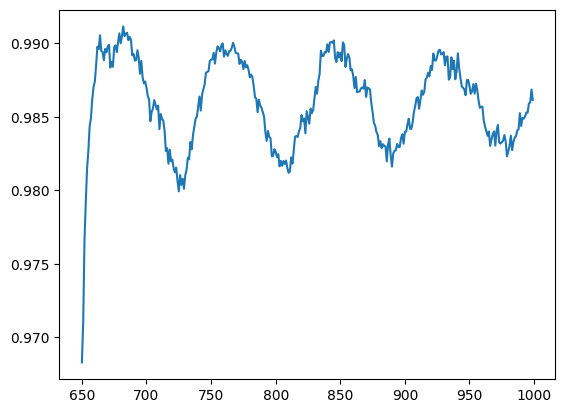

In [128]:
plt.plot(keff)

In [129]:
def generate_histogram(data: np.ndarray, binInt = 1.0e-06, binMax = 1.5e-04):
    '''
    Take in a data with columns are features  Transform the features with histogram method
    '''

    # Extract data
    Xvals = data

    nRows, nCols = Xvals.shape

    # define bins
    hEdges = np.arange(0, binMax+binInt, binInt)
    nBins = len(hEdges)-1


    # fill histogram matrix
    nCountsX = np.zeros((nRows, nBins), dtype=np.uint16)
    for n in range(nRows):
        nCountsX[n,:], _ = np.histogram(Xvals[n,:], hEdges)
    return nCountsX

In [130]:
hist_data = generate_histogram(data.to_numpy())

In [131]:
data.iloc[0,:]

Cs137_0 [at/b.cm]     NaN
Cs137_1 [at/b.cm]     NaN
Cs137_2 [at/b.cm]     NaN
Cs137_3 [at/b.cm]     NaN
Cs137_4 [at/b.cm]     NaN
                       ..
Cs137_829 [at/b.cm]   NaN
Cs137_830 [at/b.cm]   NaN
Cs137_831 [at/b.cm]   NaN
Cs137_832 [at/b.cm]   NaN
Cs137_833 [at/b.cm]   NaN
Name: 650, Length: 834, dtype: float64

In [132]:
hist_data[0] # this is super wired, all cs in first row is nan

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint16)

In [133]:
# align the data such that each row is a keff and the cesian concetration from last step

# delete the fist element in keff

keff = keff.to_numpy()
keff = keff[1:]
print(keff.shape)

# delete the last row in hist_data

hist_data = hist_data[:-1]
print(hist_data.shape)

(349,)
(349, 150)


In [134]:
'''
a reminder, shoule we remove the first column since all cs is 0?
'''

'\na reminder, shoule we remove the first column since all cs is 0?\n'

In [135]:
# Then, we concentrate keff and data together

all_data = np.append(hist_data, keff.reshape(-1,1), axis=1)
all_data.shape

(349, 151)

In [136]:
# cut the data length so it can fit time sequence length, which is 10



all_data = all_data[: len(all_data)//sequence_length * sequence_length]

In [137]:
# add power and threshold


# keep the first 50 as 1 since all power and thereshold are 1
def add_one_column_after_50 (arr,new_col_value):
    # Create a new column of single value to add to the front of the array
    new_col = np.concatenate((np.ones(50), np.full((arr.shape[0]-50,), new_col_value)))

    # Use insert to insert the new column to the front of the array
    new_arr = np.insert(arr, 0, new_col, axis=1)

    return new_arr

def add_Power_and_Threshold(arr, p = 1, t = 1):
    arr = add_one_column_after_50(arr, p)
    arr = add_one_column_after_50(arr, t)

    return arr

all_data = add_Power_and_Threshold(all_data, 0.6, 1)





In [138]:
# combine all the above step

def get_data(filename, p =1, t = 1):
    df = pd.read_csv(filename, index_col= 0)

    keff, data = process(df)
    hist_data = generate_histogram(data.to_numpy())

    # delete the fist element in keff

    keff = keff.to_numpy()
    keff = keff[1:]
    # print(keff.shape)

    # delete the last row in hist_data

    hist_data = hist_data[:-1]
    # print(hist_data.shape)

    all_data = np.append(hist_data, keff.reshape(-1,1), axis=1)


    all_data = all_data[: len(all_data)//sequence_length * sequence_length]

    all_data = add_Power_and_Threshold(all_data, p ,t)

    return all_data
    


In [139]:
# lets get the data

header = './gdrive/MyDrive/SimpleLSTM'

P1T1_to_P06T1 = get_data( header +'/transiant_data/P1T1_to_P0.6T1.csv',0.6,1)

P1T1_to_P08T1 = get_data( header+ '/transiant_data/P1T1_to_P0.8T1.csv',0.8,1)

P1T1_to_P1T11 = get_data( header + '/transiant_data/P1T1_to_P1T1.1.csv',1,1.1)

P1T1_to_P1T09 = get_data(header + '/transiant_data/P1T1_to_P1T0.9.csv',1,0.9)




In [140]:
P1T1_to_P06T1.shape

(340, 153)

In [141]:
# concentrate all data together and do the standarlize
add_order = [P1T1_to_P06T1,P1T1_to_P08T1,P1T1_to_P1T11,P1T1_to_P1T09]
all_data = np.concatenate(add_order, axis=0)
all_data.shape

(1360, 153)

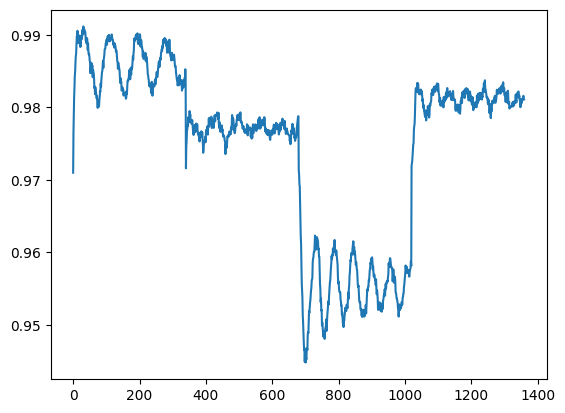

In [142]:
plt.plot(all_data[:,-1])

### Add stable data

In [143]:
# then, we need to add the stable data to the training set
stable_data = np.loadtxt('./gdrive/MyDrive/SimpleLSTM/stable_data.csv', delimiter= ',', dtype= np.float64)
print(stable_data.shape)

(1600, 153)


In [144]:
all_data = np.concatenate([all_data, stable_data], axis = 0)

### Do the standarlize

In [145]:
data = all_data

ss = StandardScaler()

data = ss.fit_transform(data)


clean_data = data.copy()

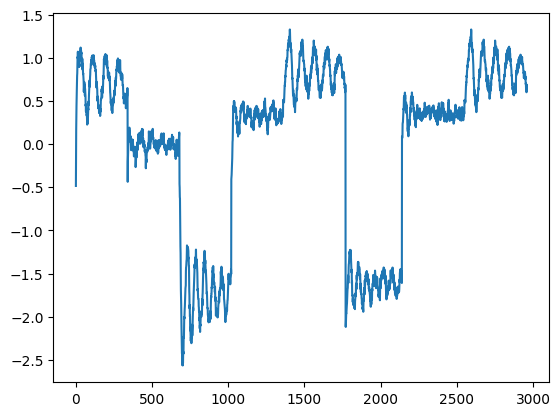

In [146]:
plt.plot(data[:,-1])

In [148]:
# define the training and testing set
training_data = ReactorData(data,sequence_length,0,1)


testing_data = ReactorData(data,sequence_length,0.75,1)

training_and_testing_data = ReactorData(data,sequence_length,0,1)

### Training 

In [149]:
# define neural nets

input_dim = training_data[0][0].shape[1]



# print(output_dim)

# some adjustable hyper-parameters
nets_hyper_parameters = {
'input_dim' : input_dim,
'output_dim' : 1,
'hidden_dim' : 256,
'lstm_nums_layer' : 2,
'dropout' : 0.2 
}


model = SimpleLSTM(**nets_hyper_parameters).to(device)

In [152]:
optimizer_parameters = {
    'params':model.parameters(),
    'lr' : 0.001,
    'weight_decay' : 0.01
}


train_parameters = {
    'model' : model,
    'training_data' : training_data,
    'epoch_num': 200,
    'batch_size':batch_size,
    'optimizer' : optim.Adam(**optimizer_parameters),
    'loss_fn' : nn.MSELoss().to(device),
    'print_out_frequency': 20,
    'shuffle': True,
    'device' : device

}


model, _ = train(** train_parameters)

The loss is 0.43013876339350665 in epoch 0
The loss is 0.17905310893193618 in epoch 20
The loss is 0.05055785068098171 in epoch 40
The loss is 0.3043830798224132 in epoch 60
The loss is 0.17687492596728127 in epoch 80
The loss is 0.04311996580202831 in epoch 100
The loss is 0.13663311458515878 in epoch 120
The loss is 0.04108347148342281 in epoch 140
The loss is 0.025040202705564986 in epoch 160
The loss is 0.04124202135328161 in epoch 180
Training is finished, the final loss is 0.05199507275994972


In [158]:
print(next(model.parameters()).device)

cuda:0


### Visualize the traning result

In [163]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def eval(data, batch_size, sequence_length):
    model.to('cpu')
    # Assuming you have a DataSet object called 'training_data' and a trained model called 'model'
    training_set = data
    # Step 1: Create a DataLoader from your DataSet object
    batch_size = batch_size  # Adjust this value based on your model's input requirements
    train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=False)

    # Step 2 & 3: Iterate through the DataLoader and collect predictions and true labels
    predictions = []
    true_labels = []

    sequence_length = sequence_length  # Assuming a sequence length of 10

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in train_loader:


            # Pass the input data to the trained model and collect the predictions
            preds = model(inputs)
            preds = preds.reshape(-1, sequence_length)  # Reshape the predictions to (batch_size, sequence_length, output_dim)
            predictions.extend(preds.squeeze().view(-1).tolist())  # Flatten the predictions
            true_labels.extend(labels.squeeze().view(-1).tolist())  # Flatten the true labels

    # Step 4: Plot the predictions and true labels for comparison
    plt.figure()
    plt.xlabel('Timestamp')
    plt.ylabel('Keff')
    plt.plot(true_labels, label="Real")
    plt.plot(predictions, label="Predict", alpha = 0.6)
    plt.legend()
    plt.show()

    return np.array(true_labels), np.array(predictions)


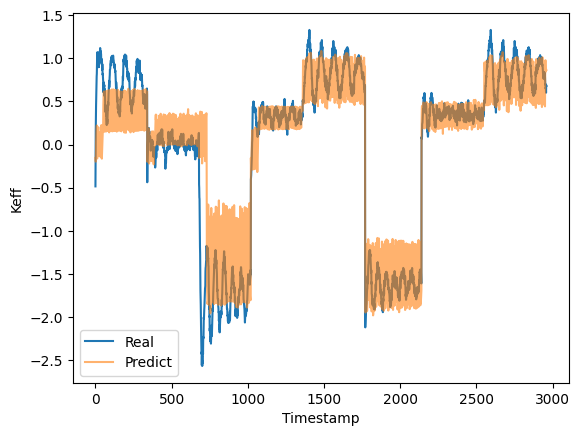

In [164]:
training_label, training_pred =  eval(training_data, batch_size, sequence_length)

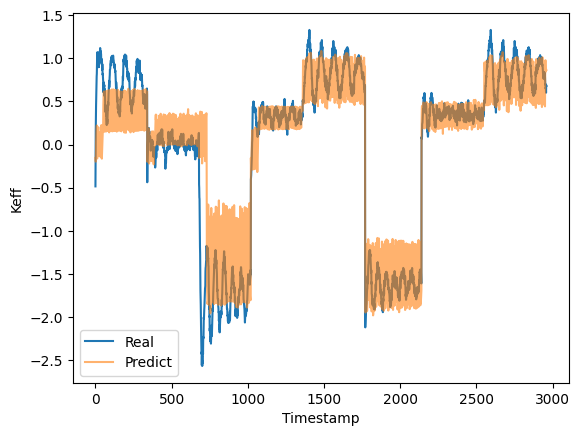

In [166]:
all_label, all_pred =  eval(training_data, batch_size, sequence_length)

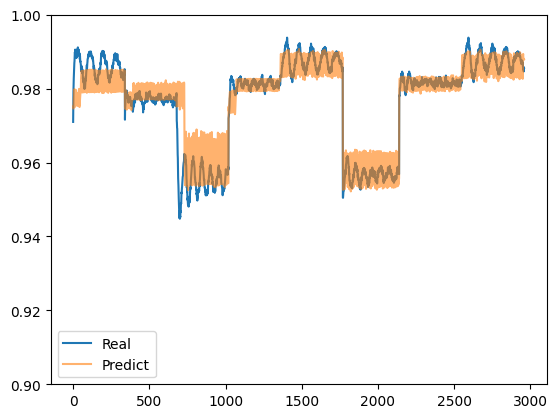

In [169]:
# change to the original unit
true_labels = all_label
predictions = all_pred
X = training_and_testing_data.unshaped_data

result_y = np.append(X, true_labels.reshape(-1,1), axis=1)
result_predict = np.append(X, predictions.reshape(-1,1), axis=1)

y = ss.inverse_transform(result_y)
predict = ss.inverse_transform(result_predict)

plt.figure()
plt.ylim((0.9,1))
plt.plot(y[:,-1], label = "Real")     
plt.plot(predict[:,-1], label = "Predict", alpha = 0.6)
plt.legend()


In [168]:
'''
some points

should add some stable data?
should increse model size?
should do some more data prepocessing?
should use pre-trained model?
'''

'\nsome points\n\nshould add some stable data?\nshould increse model size?\nshould do some more data prepocessing?\nshould use pre-trained model?\n'